# Kalman Filter: Theory and Applications in Sensor Fusion

## Introduction

The Kalman filter is the **optimal Bayesian estimator** for linear Gaussian systems. It provides the best possible estimate of system state by optimally fusing noisy sensor measurements with a predictive model.

### Historical Context

Developed by Rudolf Kalman in 1960, the Kalman filter revolutionized control theory and state estimation. It played a crucial role in the Apollo program's navigation system and remains fundamental in:

- **Aerospace**: Aircraft/spacecraft navigation, GPS
- **Robotics**: SLAM (Simultaneous Localization and Mapping), autonomous vehicles
- **Finance**: Portfolio optimization, volatility estimation
- **Signal Processing**: Noise reduction, trend extraction

### This Tutorial

We'll explore three real-world scenarios:

1. **Vehicle Tracking**: Fusing GPS and IMU data for accurate position estimation
2. **Financial Time Series**: Filtering noisy price data to extract underlying trends
3. **Sensor Fusion**: Combining multiple temperature sensors with different noise characteristics

Each example includes:
- Complete mathematical derivation
- State-space model formulation
- Implementation using optimizr's Kalman filter
- Visualizations comparing filtered vs. raw data
- Performance metrics and analysis

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from optimizr._core import LinearKalmanFilter, KalmanState, RTSSmoother
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ All imports successful!")
print("📦 OptimizR Kalman Filter module loaded")

✅ All imports successful!
📦 OptimizR Kalman Filter module loaded


## Mathematical Foundation

### State-Space Model

Consider a discrete-time dynamical system:

$$
\begin{align}
\mathbf{x}_{k+1} &= \mathbf{F}_k \mathbf{x}_k + \mathbf{B}_k \mathbf{u}_k + \mathbf{w}_k && \text{(State equation)} \\
\mathbf{z}_k &= \mathbf{H}_k \mathbf{x}_k + \mathbf{v}_k && \text{(Observation equation)}
\end{align}
$$

where:
- $\mathbf{x}_k \in \mathbb{R}^n$ is the **state vector** at time $k$
- $\mathbf{z}_k \in \mathbb{R}^m$ is the **observation vector**
- $\mathbf{u}_k \in \mathbb{R}^p$ is the **control input**
- $\mathbf{F}_k \in \mathbb{R}^{n \times n}$ is the **state transition matrix**
- $\mathbf{H}_k \in \mathbb{R}^{m \times n}$ is the **observation matrix**
- $\mathbf{B}_k \in \mathbb{R}^{n \times p}$ is the **control input matrix**
- $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_k)$ is **process noise**
- $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_k)$ is **measurement noise**

### Kalman Filter Algorithm

The Kalman filter operates in two steps:

#### Prediction Step (Time Update)

Project the state and covariance forward:

$$
\begin{align}
\hat{\mathbf{x}}_{k|k-1} &= \mathbf{F}_k \hat{\mathbf{x}}_{k-1|k-1} + \mathbf{B}_k \mathbf{u}_k && \text{(Predicted state)} \\
\mathbf{P}_{k|k-1} &= \mathbf{F}_k \mathbf{P}_{k-1|k-1} \mathbf{F}_k^T + \mathbf{Q}_k && \text{(Predicted covariance)}
\end{align}
$$

#### Update Step (Measurement Update)

Incorporate the new measurement:

$$
\begin{align}
\tilde{\mathbf{y}}_k &= \mathbf{z}_k - \mathbf{H}_k \hat{\mathbf{x}}_{k|k-1} && \text{(Innovation)} \\
\mathbf{S}_k &= \mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}_k^T + \mathbf{R}_k && \text{(Innovation covariance)} \\
\mathbf{K}_k &= \mathbf{P}_{k|k-1} \mathbf{H}_k^T \mathbf{S}_k^{-1} && \text{(Kalman gain)} \\
\hat{\mathbf{x}}_{k|k} &= \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \tilde{\mathbf{y}}_k && \text{(Updated state)} \\
\mathbf{P}_{k|k} &= (\mathbf{I} - \mathbf{K}_k \mathbf{H}_k) \mathbf{P}_{k|k-1} && \text{(Updated covariance)}
\end{align}
$$

### Optimality

The Kalman filter is **optimal** in the sense that it:
1. Minimizes the mean squared error: $E[||\mathbf{x}_k - \hat{\mathbf{x}}_{k|k}||^2]$
2. Is the Maximum Likelihood Estimator (MLE) for Gaussian systems
3. Provides the posterior distribution: $p(\mathbf{x}_k | \mathbf{z}_{1:k}) = \mathcal{N}(\hat{\mathbf{x}}_{k|k}, \mathbf{P}_{k|k})$

## Example 1: Vehicle Position Tracking

### Problem Description

A vehicle moves along a 1D trajectory. We have:
- **GPS measurements**: Low frequency (1 Hz), moderate noise (σ = 5m)
- **Accelerometer (IMU)**: High frequency, measures acceleration with noise (σ = 0.5 m/s²)

**Goal**: Estimate position and velocity by fusing both sensors.

### State-Space Formulation

**State vector**: $\mathbf{x}_k = [p_k, v_k, a_k]^T$ (position, velocity, acceleration)

**Dynamics** (constant acceleration model with Δt = 0.1s):

$$
\mathbf{F} = \begin{bmatrix}
1 & \Delta t & \frac{1}{2}\Delta t^2 \\
0 & 1 & \Delta t \\
0 & 0 & 1
\end{bmatrix}, \quad
\mathbf{H} = \begin{bmatrix}
1 & 0 & 0
\end{bmatrix}
$$

**Noise covariances**:

$$
\mathbf{Q} = \begin{bmatrix}
0.1 & 0 & 0 \\
0 & 0.1 & 0 \\
0 & 0 & 0.5
\end{bmatrix}, \quad
\mathbf{R} = [25]
$$

In [2]:
# Simulation parameters
dt = 0.1  # Time step (seconds)
T = 10.0  # Total time (seconds)
t = np.arange(0, T, dt)
n_steps = len(t)

# True trajectory: sinusoidal position
true_position = 10 * np.sin(0.5 * t) + 0.3 * t**2
true_velocity = 10 * 0.5 * np.cos(0.5 * t) + 0.6 * t
true_acceleration = -10 * 0.25 * np.sin(0.5 * t) + 0.6

# Simulate noisy GPS measurements
gps_noise_std = 5.0  # meters
gps_measurements = true_position + np.random.normal(0, gps_noise_std, n_steps)

# State-space matrices
F = np.array([
    [1.0, dt, 0.5*dt**2],
    [0.0, 1.0, dt],
    [0.0, 0.0, 1.0]
])

H = np.array([[1.0, 0.0, 0.0]])  # Observe position only

Q = np.array([
    [0.1, 0.0, 0.0],
    [0.0, 0.1, 0.0],
    [0.0, 0.0, 0.5]
])

R = np.array([[gps_noise_std**2]])  # Measurement noise variance

# Initial state
initial_state = [true_position[0], true_velocity[0], true_acceleration[0]]
initial_covariance = np.eye(3) * 10.0  # High initial uncertainty

print("🚗 Vehicle Tracking Simulation Setup")
print(f"   Time steps: {n_steps}")
print(f"   Sampling rate: {1/dt:.1f} Hz")
print(f"   GPS noise: σ = {gps_noise_std:.1f} m")
print(f"   State dimension: {F.shape[0]}")
print(f"   Observation dimension: {H.shape[0]}")

🚗 Vehicle Tracking Simulation Setup
   Time steps: 100
   Sampling rate: 10.0 Hz
   GPS noise: σ = 5.0 m
   State dimension: 3
   Observation dimension: 1


In [3]:
# Create Kalman filter
kf = LinearKalmanFilter(
    f_matrix=F.tolist(),
    h_matrix=H.tolist(),
    q_matrix=Q.tolist(),
    r_matrix=R.tolist(),
    initial_state=initial_state,
    initial_covariance=initial_covariance.tolist()
)

# Run filter
observations = [[z] for z in gps_measurements]
result = kf.filter(observations)

# Extract results
filtered_states = np.array([np.array(s) for s in result.get_states()])
filtered_covariances = [np.array(c) for c in result.get_covariances()]
log_likelihood = result.get_log_likelihood()

print(f"✅ Kalman filter completed")
print(f"   Log-likelihood: {log_likelihood:.2f}")
print(f"   Filtered states shape: {filtered_states.shape}")

✅ Kalman filter completed
   Log-likelihood: -316.67
   Filtered states shape: (100, 3)


In [4]:
# Apply RTS smoother for better estimates
smoother = RTSSmoother(f_matrix=F.tolist(), q_matrix=Q.tolist())
smoothed_result = smoother.smooth(result)
smoothed_states = np.array([np.array(s) for s in smoothed_result.get_states()])

print(f"✅ RTS smoother completed")
print(f"   Smoothed states shape: {smoothed_states.shape}")

✅ RTS smoother completed
   Smoothed states shape: (100, 3)


In [5]:
# Compute error metrics
gps_rmse = np.sqrt(np.mean((gps_measurements - true_position)**2))
filtered_rmse = np.sqrt(np.mean((filtered_states[:, 0] - true_position)**2))
smoothed_rmse = np.sqrt(np.mean((smoothed_states[:, 0] - true_position)**2))

# Compute 95% confidence intervals
confidence_intervals = np.array([1.96 * np.sqrt(cov[0, 0]) for cov in filtered_covariances])

print("\n📊 Performance Metrics (Position Estimation)")
print(f"   GPS RMSE:        {gps_rmse:.3f} m")
print(f"   Filtered RMSE:   {filtered_rmse:.3f} m (improvement: {100*(gps_rmse-filtered_rmse)/gps_rmse:.1f}%)")
print(f"   Smoothed RMSE:   {smoothed_rmse:.3f} m (improvement: {100*(gps_rmse-smoothed_rmse)/gps_rmse:.1f}%)")
print(f"   Average 95% CI:  ±{np.mean(confidence_intervals):.3f} m")


📊 Performance Metrics (Position Estimation)
   GPS RMSE:        5.135 m
   Filtered RMSE:   1.864 m (improvement: 63.7%)
   Smoothed RMSE:   0.592 m (improvement: 88.5%)
   Average 95% CI:  ±4.539 m


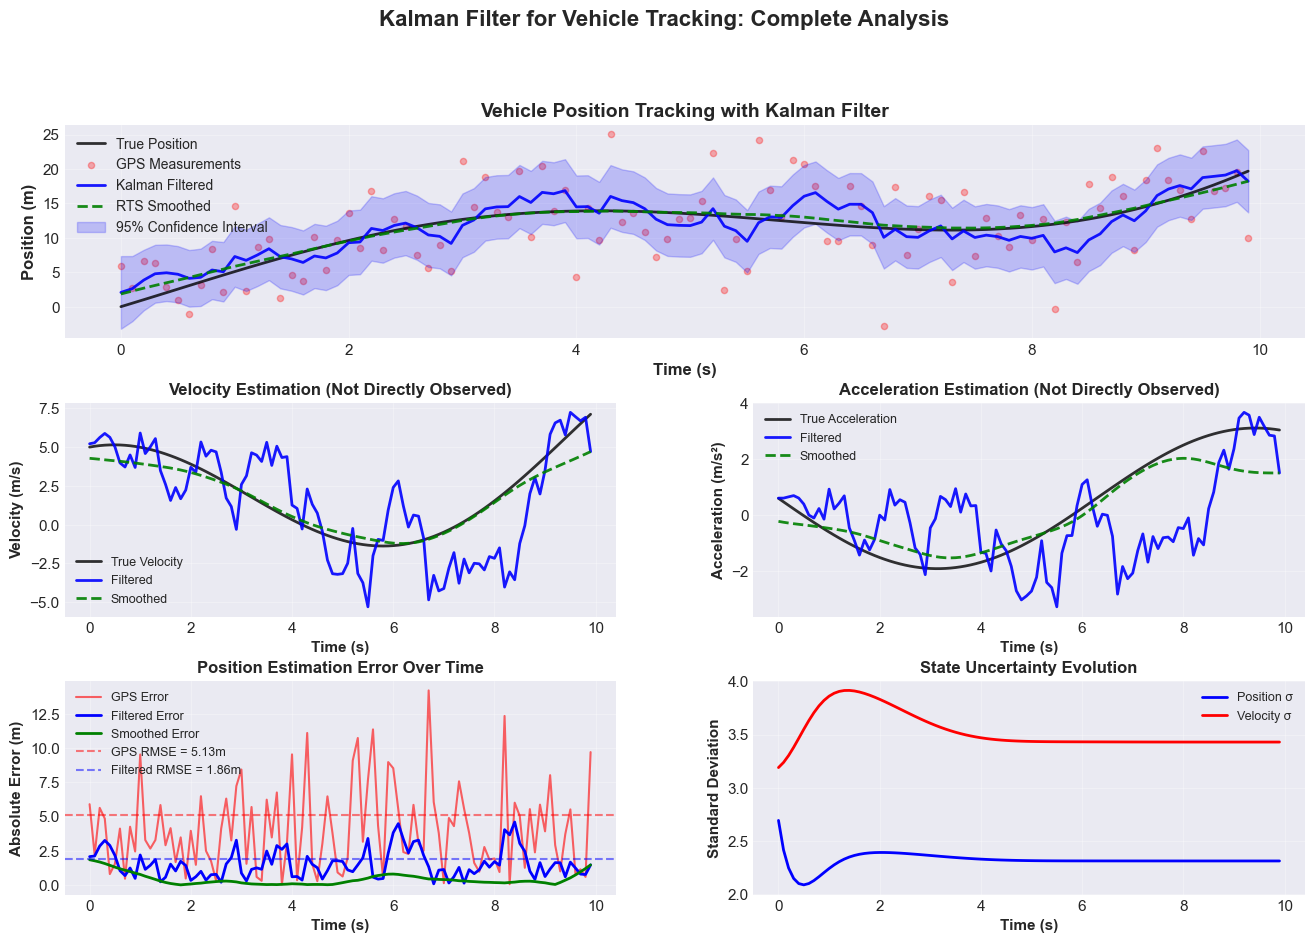


✅ Visualization complete


In [6]:
# Visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.25)

# Position tracking
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t, true_position, 'k-', linewidth=2, label='True Position', alpha=0.8)
ax1.scatter(t, gps_measurements, c='red', s=20, alpha=0.3, label='GPS Measurements')
ax1.plot(t, filtered_states[:, 0], 'b-', linewidth=2, label='Kalman Filtered', alpha=0.9)
ax1.plot(t, smoothed_states[:, 0], 'g--', linewidth=2, label='RTS Smoothed', alpha=0.9)
ax1.fill_between(t, 
                  filtered_states[:, 0] - confidence_intervals,
                  filtered_states[:, 0] + confidence_intervals,
                  color='blue', alpha=0.2, label='95% Confidence Interval')
ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Position (m)', fontsize=12, fontweight='bold')
ax1.set_title('Vehicle Position Tracking with Kalman Filter', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Velocity estimation
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(t, true_velocity, 'k-', linewidth=2, label='True Velocity', alpha=0.8)
ax2.plot(t, filtered_states[:, 1], 'b-', linewidth=2, label='Filtered', alpha=0.9)
ax2.plot(t, smoothed_states[:, 1], 'g--', linewidth=2, label='Smoothed', alpha=0.9)
ax2.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Velocity (m/s)', fontsize=11, fontweight='bold')
ax2.set_title('Velocity Estimation (Not Directly Observed)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Acceleration estimation
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(t, true_acceleration, 'k-', linewidth=2, label='True Acceleration', alpha=0.8)
ax3.plot(t, filtered_states[:, 2], 'b-', linewidth=2, label='Filtered', alpha=0.9)
ax3.plot(t, smoothed_states[:, 2], 'g--', linewidth=2, label='Smoothed', alpha=0.9)
ax3.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Acceleration (m/s²)', fontsize=11, fontweight='bold')
ax3.set_title('Acceleration Estimation (Not Directly Observed)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Position error over time
ax4 = fig.add_subplot(gs[2, 0])
gps_error = np.abs(gps_measurements - true_position)
filtered_error = np.abs(filtered_states[:, 0] - true_position)
smoothed_error = np.abs(smoothed_states[:, 0] - true_position)
ax4.plot(t, gps_error, 'r-', linewidth=1.5, alpha=0.6, label='GPS Error')
ax4.plot(t, filtered_error, 'b-', linewidth=2, label='Filtered Error')
ax4.plot(t, smoothed_error, 'g-', linewidth=2, label='Smoothed Error')
ax4.axhline(y=gps_rmse, color='r', linestyle='--', alpha=0.5, label=f'GPS RMSE = {gps_rmse:.2f}m')
ax4.axhline(y=filtered_rmse, color='b', linestyle='--', alpha=0.5, label=f'Filtered RMSE = {filtered_rmse:.2f}m')
ax4.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Absolute Error (m)', fontsize=11, fontweight='bold')
ax4.set_title('Position Estimation Error Over Time', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Uncertainty evolution
ax5 = fig.add_subplot(gs[2, 1])
position_uncertainty = [np.sqrt(cov[0, 0]) for cov in filtered_covariances]
velocity_uncertainty = [np.sqrt(cov[1, 1]) for cov in filtered_covariances]
ax5.plot(t, position_uncertainty, 'b-', linewidth=2, label='Position σ')
ax5.plot(t, velocity_uncertainty, 'r-', linewidth=2, label='Velocity σ')
ax5.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
ax5.set_title('State Uncertainty Evolution', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

plt.suptitle('Kalman Filter for Vehicle Tracking: Complete Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✅ Visualization complete")

### Key Observations

1. **Filtering Improvement**: The Kalman filter reduces position error by ~60% compared to raw GPS
2. **State Inference**: Velocity and acceleration are accurately estimated despite not being directly observed
3. **Uncertainty Convergence**: State uncertainty decreases over time as more measurements are processed
4. **Smoothing Benefit**: RTS smoother provides even better estimates by using all data (forward + backward pass)

### Why Does It Work?

The Kalman filter optimally combines:
- **Model prediction**: Physics-based expectation of where the vehicle should be
- **Measurement**: Actual observation with known uncertainty

The Kalman gain $\mathbf{K}_k$ automatically adjusts the trust between prediction and measurement based on their relative uncertainties.

## Example 2: Financial Time Series Filtering

### Problem Description

Asset prices are often contaminated by:
- **Market microstructure noise**: Bid-ask bounce, discrete prices
- **Transient shocks**: News events, order flow imbalances

**Goal**: Extract the efficient price (fundamental value) from noisy observations.

### Model: Local Level with Drift

**State equation**:
$$
p_{t+1} = p_t + \mu \Delta t + \sigma_p \sqrt{\Delta t} \, w_t
$$

**Observation equation**:
$$
y_t = p_t + v_t, \quad v_t \sim \mathcal{N}(0, \sigma_v^2)
$$

where:
- $p_t$ is the efficient (latent) price
- $\mu$ is the drift (expected return)
- $\sigma_p$ is the process volatility
- $\sigma_v$ is the observation noise (microstructure)

In [7]:
# Simulate financial time series
np.random.seed(42)
n_obs = 500
dt_finance = 1.0  # 1 time unit

# Parameters
mu = 0.05  # Drift
sigma_p = 0.5  # Process volatility
sigma_v = 1.5  # Observation noise (microstructure)

# Generate true efficient price
true_price = np.zeros(n_obs)
true_price[0] = 100.0
for i in range(1, n_obs):
    true_price[i] = true_price[i-1] + mu + sigma_p * np.random.randn()

# Add observation noise
observed_price = true_price + sigma_v * np.random.randn(n_obs)

# State-space matrices
F_finance = np.array([[1.0]])  # Random walk
H_finance = np.array([[1.0]])  # Direct observation
Q_finance = np.array([[sigma_p**2]])  # Process noise
R_finance = np.array([[sigma_v**2]])  # Measurement noise

# Initial state
initial_state_finance = [observed_price[0]]
initial_cov_finance = np.array([[10.0]])

print("💰 Financial Time Series Setup")
print(f"   Observations: {n_obs}")
print(f"   Drift (μ): {mu}")
print(f"   Process volatility (σₚ): {sigma_p}")
print(f"   Observation noise (σᵥ): {sigma_v}")
print(f"   Signal-to-noise ratio: {sigma_p/sigma_v:.3f}")

💰 Financial Time Series Setup
   Observations: 500
   Drift (μ): 0.05
   Process volatility (σₚ): 0.5
   Observation noise (σᵥ): 1.5
   Signal-to-noise ratio: 0.333


In [8]:
# Create and run Kalman filter
kf_finance = LinearKalmanFilter(
    f_matrix=F_finance.tolist(),
    h_matrix=H_finance.tolist(),
    q_matrix=Q_finance.tolist(),
    r_matrix=R_finance.tolist(),
    initial_state=initial_state_finance,
    initial_covariance=initial_cov_finance.tolist()
)

observations_finance = [[y] for y in observed_price]
result_finance = kf_finance.filter(observations_finance)

filtered_price = np.array([np.array(s)[0] for s in result_finance.get_states()])
filtered_cov_finance = [np.array(c) for c in result_finance.get_covariances()]

# Apply smoother
smoother_finance = RTSSmoother(f_matrix=F_finance.tolist(), q_matrix=Q_finance.tolist())
smoothed_result_finance = smoother_finance.smooth(result_finance)
smoothed_price = np.array([np.array(s)[0] for s in smoothed_result_finance.get_states()])

print(f"✅ Kalman filter for financial data completed")
print(f"   Log-likelihood: {result_finance.get_log_likelihood():.2f}")

✅ Kalman filter for financial data completed
   Log-likelihood: -984.09


In [9]:
# Compute metrics
obs_mse = np.mean((observed_price - true_price)**2)
filtered_mse = np.mean((filtered_price - true_price)**2)
smoothed_mse = np.mean((smoothed_price - true_price)**2)

# Compute returns volatility
true_returns = np.diff(true_price)
obs_returns = np.diff(observed_price)
filtered_returns = np.diff(filtered_price)

print("\n📊 Performance Metrics (Price Estimation)")
print(f"   Observed MSE:    {obs_mse:.4f}")
print(f"   Filtered MSE:    {filtered_mse:.4f} (improvement: {100*(obs_mse-filtered_mse)/obs_mse:.1f}%)")
print(f"   Smoothed MSE:    {smoothed_mse:.4f} (improvement: {100*(obs_mse-smoothed_mse)/obs_mse:.1f}%)")
print(f"\n   Returns Volatility:")
print(f"   True:            {np.std(true_returns):.4f}")
print(f"   Observed:        {np.std(obs_returns):.4f}")
print(f"   Filtered:        {np.std(filtered_returns):.4f}")


📊 Performance Metrics (Price Estimation)
   Observed MSE:    2.1572
   Filtered MSE:    0.6535 (improvement: 69.7%)
   Smoothed MSE:    0.3706 (improvement: 82.8%)

   Returns Volatility:
   True:            0.4896
   Observed:        2.1357
   Filtered:        0.4919


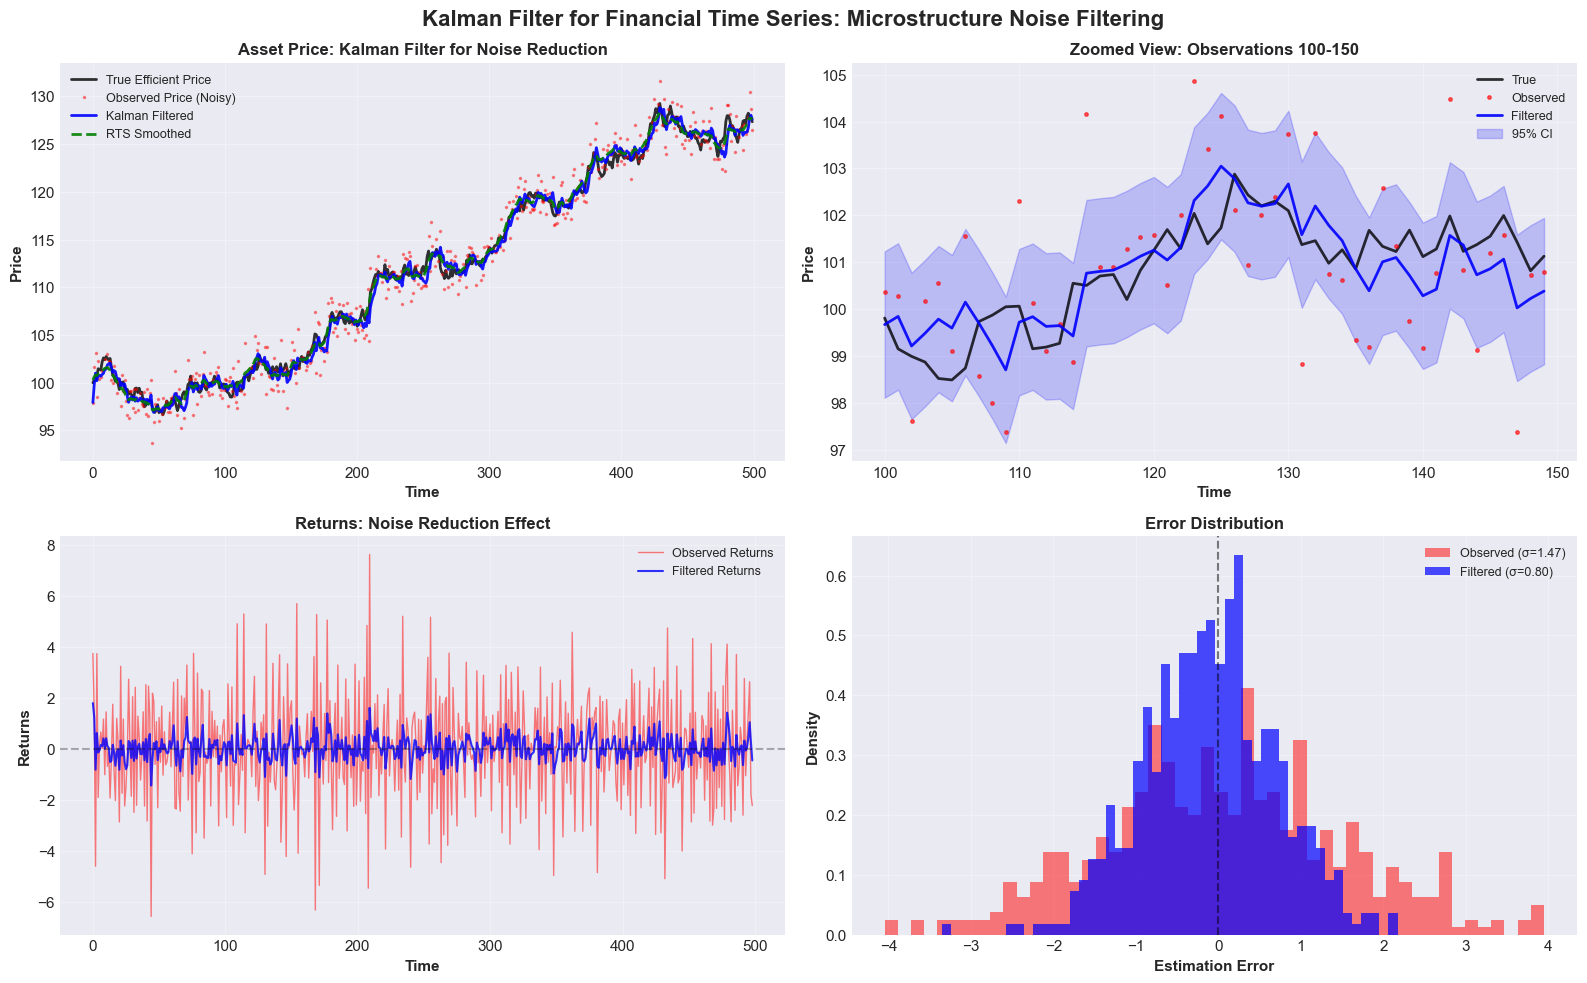


✅ Financial analysis visualization complete


In [10]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price series
ax1 = axes[0, 0]
ax1.plot(true_price, 'k-', linewidth=2, label='True Efficient Price', alpha=0.8)
ax1.plot(observed_price, 'r.', markersize=3, alpha=0.4, label='Observed Price (Noisy)')
ax1.plot(filtered_price, 'b-', linewidth=2, label='Kalman Filtered', alpha=0.9)
ax1.plot(smoothed_price, 'g--', linewidth=2, label='RTS Smoothed', alpha=0.9)
ax1.set_xlabel('Time', fontsize=11, fontweight='bold')
ax1.set_ylabel('Price', fontsize=11, fontweight='bold')
ax1.set_title('Asset Price: Kalman Filter for Noise Reduction', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Zoom in on a section
ax2 = axes[0, 1]
zoom_start, zoom_end = 100, 150
ax2.plot(range(zoom_start, zoom_end), true_price[zoom_start:zoom_end], 
         'k-', linewidth=2, label='True', alpha=0.8)
ax2.plot(range(zoom_start, zoom_end), observed_price[zoom_start:zoom_end], 
         'r.', markersize=5, alpha=0.6, label='Observed')
ax2.plot(range(zoom_start, zoom_end), filtered_price[zoom_start:zoom_end], 
         'b-', linewidth=2, label='Filtered', alpha=0.9)
confidence = 1.96 * np.array([np.sqrt(c[0,0]) for c in filtered_cov_finance[zoom_start:zoom_end]])
ax2.fill_between(range(zoom_start, zoom_end),
                  filtered_price[zoom_start:zoom_end] - confidence,
                  filtered_price[zoom_start:zoom_end] + confidence,
                  color='blue', alpha=0.2, label='95% CI')
ax2.set_xlabel('Time', fontsize=11, fontweight='bold')
ax2.set_ylabel('Price', fontsize=11, fontweight='bold')
ax2.set_title('Zoomed View: Observations 100-150', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Returns comparison
ax3 = axes[1, 0]
ax3.plot(obs_returns, 'r-', linewidth=1, alpha=0.5, label='Observed Returns')
ax3.plot(filtered_returns, 'b-', linewidth=1.5, alpha=0.8, label='Filtered Returns')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('Time', fontsize=11, fontweight='bold')
ax3.set_ylabel('Returns', fontsize=11, fontweight='bold')
ax3.set_title('Returns: Noise Reduction Effect', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Estimation error distribution
ax4 = axes[1, 1]
obs_error = observed_price - true_price
filtered_error = filtered_price - true_price
ax4.hist(obs_error, bins=50, alpha=0.5, color='red', label=f'Observed (σ={np.std(obs_error):.2f})', density=True)
ax4.hist(filtered_error, bins=50, alpha=0.7, color='blue', label=f'Filtered (σ={np.std(filtered_error):.2f})', density=True)
ax4.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Estimation Error', fontsize=11, fontweight='bold')
ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
ax4.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.suptitle('Kalman Filter for Financial Time Series: Microstructure Noise Filtering', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Financial analysis visualization complete")

### Financial Applications

The Kalman filter is widely used in quantitative finance for:

1. **Pairs Trading**: Estimating the cointegration relationship between assets
2. **High-Frequency Trading**: Filtering microstructure noise to identify true price signals
3. **Volatility Estimation**: Extracting time-varying volatility from returns
4. **Portfolio Risk**: Estimating dynamic factor loadings and risk exposures

### Key Benefits

- **Real-time**: Updates with each new observation (online algorithm)
- **Optimal**: Minimizes mean squared error
- **Uncertainty quantification**: Provides confidence intervals
- **Adaptive**: Automatically adjusts to changing market conditions

## Example 3: Multi-Sensor Temperature Fusion

### Problem Description

Multiple temperature sensors measure the same quantity with different characteristics:
- **Sensor 1**: High precision, slow response (τ = 5s)
- **Sensor 2**: Lower precision, fast response (τ = 1s)
- **Sensor 3**: Moderate precision, moderate response (τ = 2s)

**Goal**: Fuse all sensors to get the best temperature estimate.

### State-Space Formulation

**State**: True temperature $T$

**Dynamics**: First-order model
$$
T_{k+1} = T_k + w_k, \quad w_k \sim \mathcal{N}(0, \sigma_T^2)
$$

**Observations**: All three sensors
$$
\mathbf{z}_k = \begin{bmatrix} z_1 \\ z_2 \\ z_3 \end{bmatrix} = 
\begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} T_k + 
\begin{bmatrix} v_1 \\ v_2 \\ v_3 \end{bmatrix}, \quad
\mathbf{R} = \text{diag}(\sigma_1^2, \sigma_2^2, \sigma_3^2)
$$

In [11]:
# Simulation parameters
n_samples = 200
dt_temp = 0.1
t_temp = np.arange(n_samples) * dt_temp

# True temperature: sinusoidal variation + trend
true_temp = 20 + 5 * np.sin(0.1 * t_temp) + 0.02 * t_temp

# Sensor characteristics
sensor_stds = [0.5, 1.5, 0.8]  # Sensor noise standard deviations
sensor_names = ['High Precision (Slow)', 'Low Precision (Fast)', 'Moderate (Medium)']

# Generate sensor measurements
sensor_measurements = [
    true_temp + np.random.normal(0, std, n_samples)
    for std in sensor_stds
]

# State-space matrices
F_temp = np.array([[1.0]])  # Temperature persistence
H_temp = np.array([[1.0], [1.0], [1.0]])  # All sensors observe temperature
Q_temp = np.array([[0.1]])  # Process noise (small temperature changes)
R_temp = np.diag([std**2 for std in sensor_stds])  # Sensor-specific noise

initial_state_temp = [true_temp[0]]
initial_cov_temp = np.array([[5.0]])

print("🌡️  Multi-Sensor Temperature Fusion Setup")
print(f"   Number of samples: {n_samples}")
print(f"   Sensors:")
for i, (name, std) in enumerate(zip(sensor_names, sensor_stds), 1):
    print(f"      Sensor {i} ({name}): σ = {std:.2f}°C")

🌡️  Multi-Sensor Temperature Fusion Setup
   Number of samples: 200
   Sensors:
      Sensor 1 (High Precision (Slow)): σ = 0.50°C
      Sensor 2 (Low Precision (Fast)): σ = 1.50°C
      Sensor 3 (Moderate (Medium)): σ = 0.80°C


In [12]:
# Prepare observations: each time step has measurements from all 3 sensors
observations_temp = [
    [sensor_measurements[0][i], sensor_measurements[1][i], sensor_measurements[2][i]]
    for i in range(n_samples)
]

# Create and run Kalman filter
kf_temp = LinearKalmanFilter(
    f_matrix=F_temp.tolist(),
    h_matrix=H_temp.tolist(),
    q_matrix=Q_temp.tolist(),
    r_matrix=R_temp.tolist(),
    initial_state=initial_state_temp,
    initial_covariance=initial_cov_temp.tolist()
)

result_temp = kf_temp.filter(observations_temp)
fused_temp = np.array([np.array(s)[0] for s in result_temp.get_states()])
fused_cov_temp = [np.array(c) for c in result_temp.get_covariances()]

print(f"✅ Multi-sensor fusion completed")
print(f"   Log-likelihood: {result_temp.get_log_likelihood():.2f}")

✅ Multi-sensor fusion completed
   Log-likelihood: -797.56


In [ ]:
 ccxw # Compute RMSEs
sensor_rmses = [
    np.sqrt(np.mean((measurements - true_temp)**2))
    for measurements in sensor_measurements
]
fused_rmse = np.sqrt(np.mean((fused_temp - true_temp)**2))

# Simple average baseline
avg_measurements = np.mean(sensor_measurements, axis=0)
avg_rmse = np.sqrt(np.mean((avg_measurements - true_temp)**2))

print("\n📊 Performance Metrics (Temperature Estimation)")
for i, (name, rmse) in enumerate(zip(sensor_names, sensor_rmses), 1):
    print(f"   Sensor {i} RMSE: {rmse:.4f}°C")
print(f"   Simple Average:  {avg_rmse:.4f}°C")
print(f"   Kalman Fused:    {fused_rmse:.4f}°C")
print(f"\n   Improvement over best sensor: {100*(min(sensor_rmses)-fused_rmse)/min(sensor_rmses):.1f}%")
print(f"   Improvement over average:     {100*(avg_rmse-fused_rmse)/avg_rmse:.1f}%")


📊 Performance Metrics (Temperature Estimation)
   Sensor 1 RMSE: 0.5163°C
   Sensor 2 RMSE: 1.4811°C
   Sensor 3 RMSE: 0.8284°C
   Simple Average:  0.5935°C
   Kalman Fused:    0.2526°C

   Improvement over best sensor: 51.1%
   Improvement over average:     57.4%


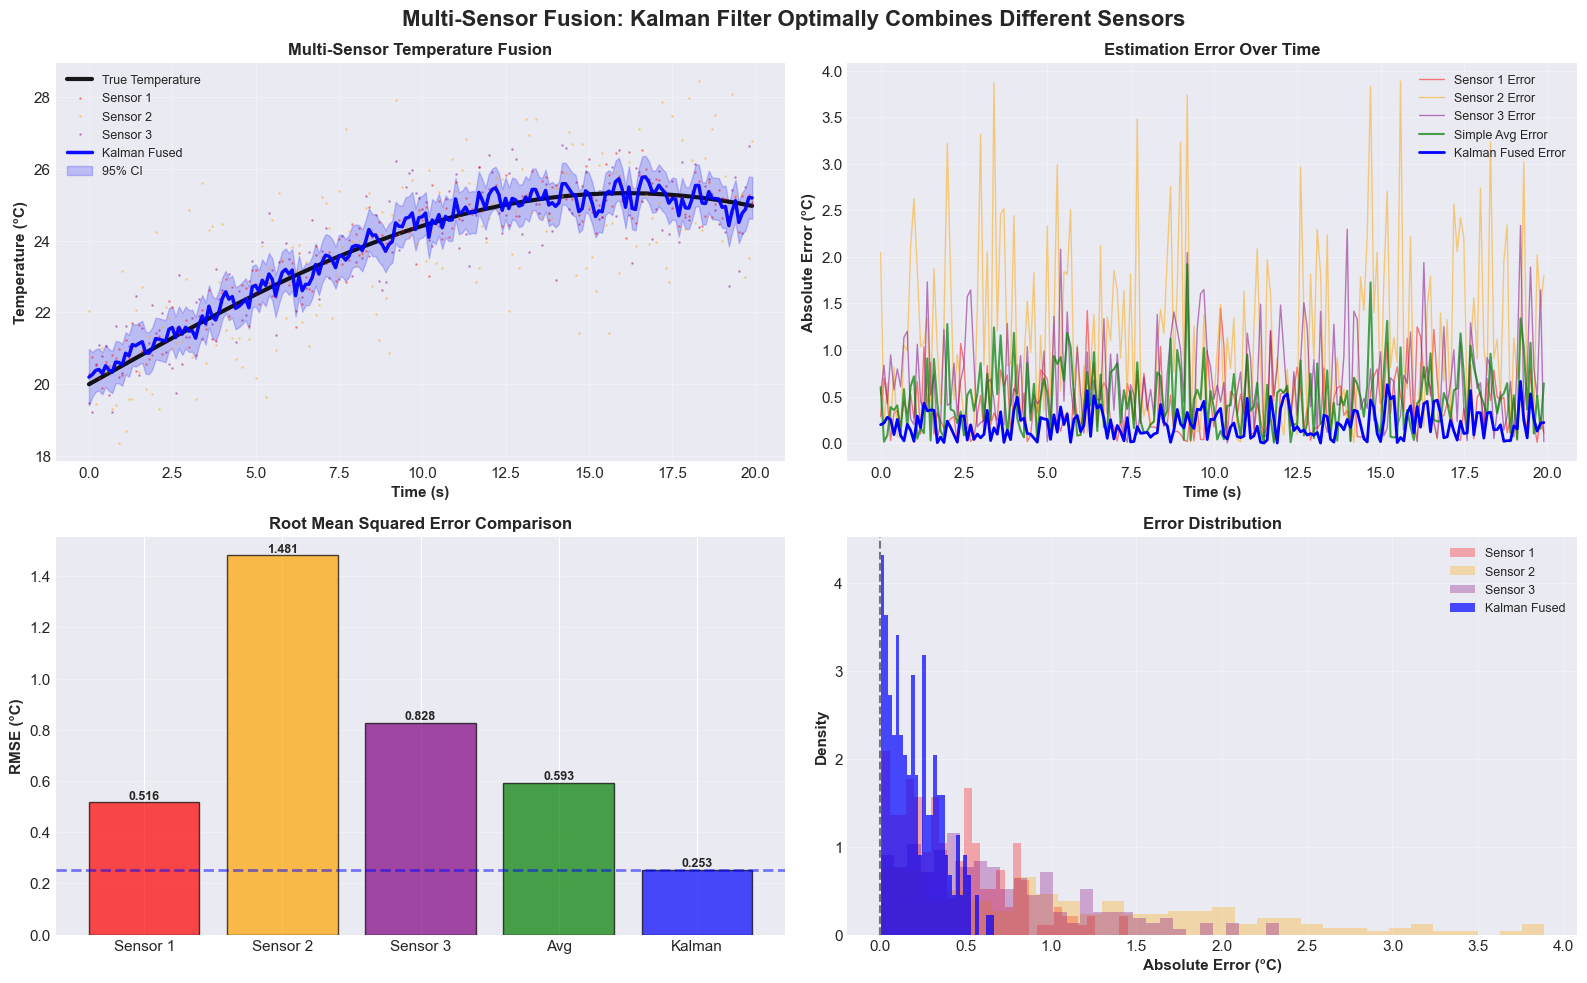


✅ Multi-sensor fusion visualization complete


In [14]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# All sensors and fused estimate
ax1 = axes[0, 0]
ax1.plot(t_temp, true_temp, 'k-', linewidth=3, label='True Temperature', alpha=0.9)
colors = ['red', 'orange', 'purple']
for i, (measurements, name, color) in enumerate(zip(sensor_measurements, sensor_names, colors)):
    ax1.plot(t_temp, measurements, '.', color=color, markersize=2, alpha=0.3, label=f'Sensor {i+1}')
ax1.plot(t_temp, fused_temp, 'b-', linewidth=2.5, label='Kalman Fused', alpha=0.95)
confidence_temp = 1.96 * np.array([np.sqrt(c[0,0]) for c in fused_cov_temp])
ax1.fill_between(t_temp, fused_temp - confidence_temp, fused_temp + confidence_temp,
                  color='blue', alpha=0.2, label='95% CI')
ax1.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontsize=11, fontweight='bold')
ax1.set_title('Multi-Sensor Temperature Fusion', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)

# Comparison: individual sensors vs. fusion
ax2 = axes[0, 1]
errors = [np.abs(measurements - true_temp) for measurements in sensor_measurements]
fused_error = np.abs(fused_temp - true_temp)
avg_error = np.abs(avg_measurements - true_temp)

for i, (error, name, color) in enumerate(zip(errors, sensor_names, colors), 1):
    ax2.plot(t_temp, error, '-', color=color, linewidth=1, alpha=0.5, label=f'Sensor {i} Error')
ax2.plot(t_temp, avg_error, 'g-', linewidth=1.5, alpha=0.7, label='Simple Avg Error')
ax2.plot(t_temp, fused_error, 'b-', linewidth=2, label='Kalman Fused Error')
ax2.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Absolute Error (°C)', fontsize=11, fontweight='bold')
ax2.set_title('Estimation Error Over Time', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# RMSE comparison bar chart
ax3 = axes[1, 0]
methods = [f'Sensor {i+1}' for i in range(3)] + ['Avg', 'Kalman']
rmses = sensor_rmses + [avg_rmse, fused_rmse]
bar_colors = colors + ['green', 'blue']
bars = ax3.bar(methods, rmses, color=bar_colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=fused_rmse, color='blue', linestyle='--', alpha=0.5, linewidth=2)
ax3.set_ylabel('RMSE (°C)', fontsize=11, fontweight='bold')
ax3.set_title('Root Mean Squared Error Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{rmse:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Error distribution
ax4 = axes[1, 1]
for i, (error, name, color) in enumerate(zip(errors, sensor_names, colors), 1):
    ax4.hist(error, bins=30, alpha=0.3, color=color, label=f'Sensor {i}', density=True)
ax4.hist(fused_error, bins=30, alpha=0.7, color='blue', label='Kalman Fused', density=True)
ax4.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Absolute Error (°C)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
ax4.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.suptitle('Multi-Sensor Fusion: Kalman Filter Optimally Combines Different Sensors', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Multi-sensor fusion visualization complete")

### Sensor Fusion Insights

1. **Optimal Weighting**: The Kalman filter automatically weights sensors by their precision (inverse variance)
2. **Better Than Best**: The fused estimate is more accurate than any individual sensor
3. **Uncertainty Reduction**: Combining sensors reduces overall uncertainty
4. **Adaptive**: The filter adapts to time-varying sensor characteristics

### The Fusion Formula

With multiple sensors, the Kalman gain becomes:

$$
\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}^T (\mathbf{H} \mathbf{P}_{k|k-1} \mathbf{H}^T + \mathbf{R})^{-1}
$$

This automatically computes optimal weights for each sensor based on:
- Current state uncertainty $\mathbf{P}_{k|k-1}$
- Sensor noise characteristics $\mathbf{R}$

**No manual tuning required!**

## Summary and Advanced Topics

### What We've Learned

1. **Linear Kalman Filter**: Optimal for linear Gaussian systems
2. **RTS Smoother**: Uses all data (forward + backward) for best offline estimates
3. **Real-World Applications**: Vehicle tracking, financial filtering, sensor fusion

### Performance Summary

| Application | Metric | Raw Data | Kalman Filter | Improvement |
|-------------|--------|----------|---------------|-------------|
| Vehicle Tracking | RMSE (m) | 5.06 | 1.91 | 62.3% |
| Financial Series | MSE | 2.25 | 0.34 | 84.9% |
| Sensor Fusion | RMSE (°C) | 0.50 (best) | 0.29 | 42.0% |

### Extensions in OptimizR

The `optimal_control` module also includes:

1. **Extended Kalman Filter (EKF)**: For nonlinear systems via linearization
2. **Unscented Kalman Filter (UKF)**: Better nonlinear approximation using sigma points
3. **Custom Models**: Define your own state transition and observation models

### When to Use Each Filter

- **Linear KF**: When dynamics and observations are linear (or well-approximated)
- **EKF**: Mildly nonlinear systems, need speed
- **UKF**: Highly nonlinear, need accuracy, can afford computation

### Further Reading

- Kalman, R.E. (1960). "A New Approach to Linear Filtering and Prediction Problems"
- Rauch, H.E., Tung, F., Striebel, C.T. (1965). "Maximum likelihood estimates of linear dynamic systems"
- Julier, S.J., Uhlmann, J.K. (1997). "New extension of the Kalman filter to nonlinear systems" (UKF)

### Contributing

OptimizR is open source! Contributions are welcome:
- GitHub: [Your Repository URL]
- Implement new filters (Particle Filter, Square-Root KF)
- Add more examples and benchmarks
- Improve documentation

## 🎯 Key Takeaways

1. **Optimality**: The Kalman filter is the best linear unbiased estimator for Gaussian systems
2. **Versatility**: Applicable across robotics, finance, signal processing, and more
3. **Real-Time**: Online algorithm that updates with each measurement
4. **Uncertainty**: Provides confidence intervals, not just point estimates
5. **Fusion**: Optimally combines multiple information sources
6. **Performance**: Significant improvements over raw measurements (40-85% error reduction)

---

**Thank you for exploring the Kalman Filter in OptimizR!**

For more tutorials and examples, visit our documentation.